In [1]:
#We do a calculations of total anthropogenic and CO2 only cumulative emissions to date.
#We use a set of parameters derived by Zeb using an optimizer which fits the FAIR models to the RCP emissions data. 
#We calculate the total anthropogenic and CO2 only emissions to date (1870-2011) using both RCP datasets and the 'real' 
#     dataset from Piers Forster.
#We calcualte the CO2 only contribution using a differencing approach
#Both sets are calculated using an 'external RF' as well as the emissions (which affect the temperature etc.)
#We also calculate the repsonses just driven by all anthropogenic sources.

#------------------

# Imports and Setup
import numpy as np
import pandas as pd
import scipy as sp
from scipy.ndimage.filters import gaussian_filter1d as smooth

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 14, 10
plt.rcParams['lines.linewidth'] = 1.5

font = {'weight' : 'normal',
      'size'   : 15}

plt.rc('font', **font)

from forward_multiple_GHG import fair_scm as FAIR_model
import fair_inverse_revised

In [2]:
#import piers data for total anthro RF
rf_anthro_piers = np.loadtxt("rf_a_reord.txt")
rf_anthro_piers = rf_anthro_piers.reshape((200,267))

#import median data anthro forcing from richard
rf_comps_median = np.loadtxt("Annualforcings_Mar2014_GHGrevised.txt", skiprows=4)

#sum components of file to make total...
rf_anthro_median = rf_comps_median[:,1] + rf_comps_median[:,2] + rf_comps_median[:,3] + rf_comps_median[:,4] +  rf_comps_median[:,6] + rf_comps_median[:,7] + rf_comps_median[:,8] + rf_comps_median[:,9] + rf_comps_median[:,10]  
rf_other_median = rf_comps_median[:,13] - rf_comps_median[:,14]
rf_total_median = rf_comps_median[:,13]

#set up time variable
y_0 = int(rf_comps_median[0,0])
time = rf_comps_median[:,0] 

#import magicc set params
#C_0 = 279.51
#F_2x= 3.71
#a = np.array([0.0500000000078,0.236489403703,0.299999999999,0.420651644725])
#r0 = 38.8413662651
#rC=0.0152
#rT=3.332

#other set provided by zeb
C_0 = 279.51
F_2x= 3.71
a = np.array([0.05,0.229348355268,0.3,0.413510596297])
r0 = 39.1193644809
rC= 0.0152
rT= 3.332


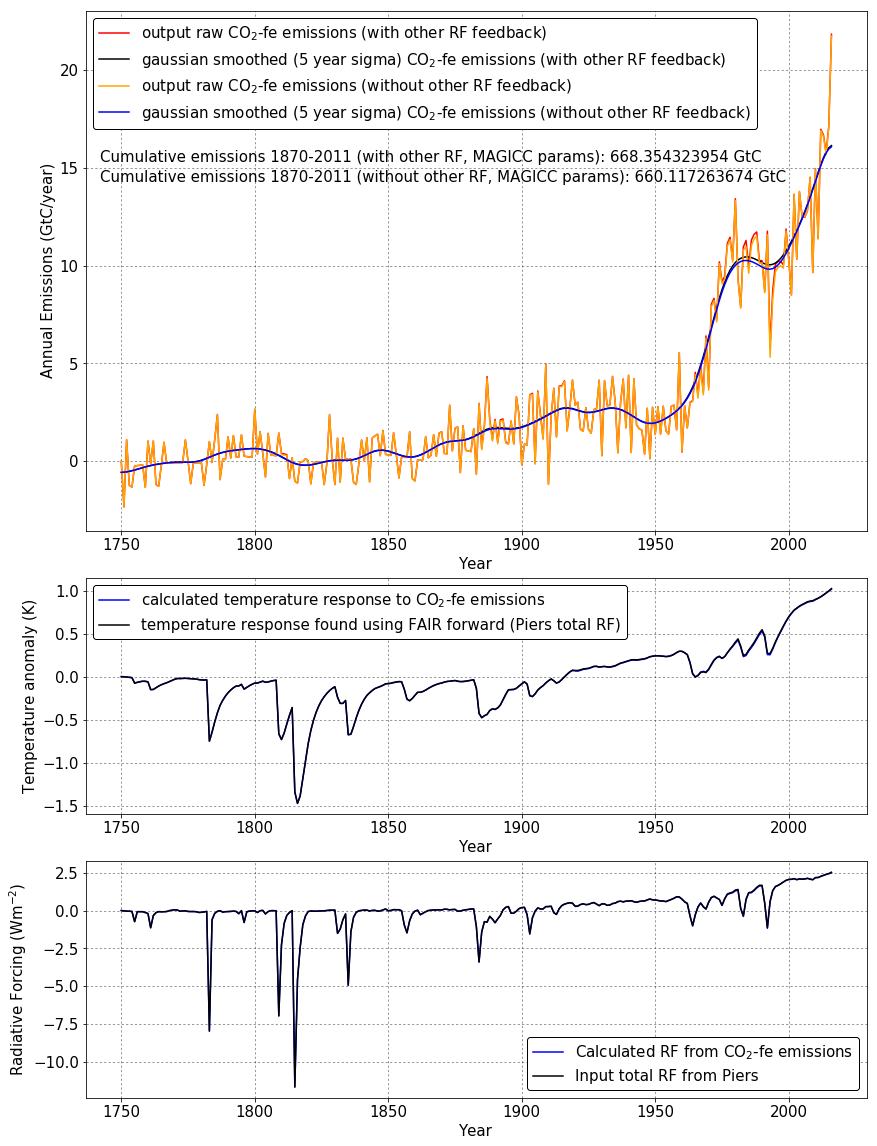

In [3]:
#MAGICC params, Piers RF data run through to find total anthro emissions.
#Use total forcing including natural sources, and tell function which bits are other rf
#   and which are as a result of emissions

#Also do just anthro RF profile run through

#-----------------

#run calcuation (MAGICC params, total forcing from Piers, telling function which bit is 'other rf')
out = FAIR_model(other_rf = rf_total_median, MAGICC_model = True, F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)
temp_total = out['temperature']
conc_total = fair_inverse_revised.forcing_to_conc(rf_total_median, RF_ext = rf_other_median, RF_ext_in = True, a = F_2x/np.log(2) , Cpreind = C_0)
ems_total, ems_total_smooth = fair_inverse_revised.conc_to_emissions(conc_total, temp_total, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)

#recalculate the temperature response due to our found emissions, prove it looks the same as the temperature profile we calculate using forward
out_resp = FAIR_model(emissions = ems_total_smooth, other_rf = rf_other_median, MAGICC_model = True, F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)
temp_resp = out_resp['temperature']
#-------------

#recalculate with just anthro RF input
out_anthro = FAIR_model(other_rf = rf_anthro_median, MAGICC_model = True, F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)
temp_anthro = out_anthro['temperature']
conc_anthro = fair_inverse_revised.forcing_to_conc(rf_anthro_median, a = F_2x/np.log(2) , Cpreind = C_0)
ems_anthro, ems_anthro_smooth = fair_inverse_revised.conc_to_emissions(conc_anthro, temp_anthro, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)

#recalculate temperature for anthro only one
out_resp_anthro = FAIR_model(emissions = ems_anthro_smooth, MAGICC_model = True, F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)
temp_resp_anthro = out_resp_anthro['temperature']
#--------------

cum_ems = np.cumsum(ems_total_smooth[1870-1750:])
cum_ems_anthro = np.cumsum(ems_anthro_smooth[1870-1750:])

#plotter set up
plt.figure(figsize = (14,20))
ax = plt.subplot2grid((4,2), (0,0), colspan = 2, rowspan = 2)
ax1 = plt.subplot2grid((4,2), (2,0), colspan = 2)
ax2 = plt.subplot2grid((4,2), (3,0), colspan = 2)

#plot emissions profile (annual)
ax.plot(time, ems_total, color = 'red', label = 'output raw CO$_2$-fe emissions (with other RF feedback)', linewidth = 1.5)
ax.plot(time, ems_total_smooth, color = 'black', label = 'gaussian smoothed (5 year sigma) CO$_2$-fe emissions (with other RF feedback)', linewidth = 1.5)
ax.plot(time, ems_anthro, color = 'orange', label = 'output raw CO$_2$-fe emissions (without other RF feedback)', linewidth = 1.5)
ax.plot(time, ems_anthro_smooth, color = 'blue', label = 'gaussian smoothed (5 year sigma) CO$_2$-fe emissions (without other RF feedback)', linewidth = 1.5)
ax.grid(True, linestyle = ':', color = 'black', alpha = 0.5)
ax.set_xlabel('Year')
ax.set_ylabel('Annual Emissions (GtC/year)')
ax.legend(loc = 'best', framealpha = 1, edgecolor = 'black')
ax.text(1742,15.3,'Cumulative emissions 1870-2011 (with other RF, MAGICC params): %s GtC' %cum_ems[2011-1870])
ax.text(1742,14.3,'Cumulative emissions 1870-2011 (without other RF, MAGICC params): %s GtC' %cum_ems_anthro[2011-1870])

#plot temperature response (forwards and backwards calculated)
ax1.plot(time, temp_resp, color = 'blue', label = 'calculated temperature response to CO$_2$-fe emissions', linewidth = 1.5)
ax1.plot(time, temp_total, color = 'black', label = 'temperature response found using FAIR forward (Piers total RF)', linewidth = 1.5)
ax1.set_xlabel('Year')
ax1.set_ylabel('Temperature anomaly (K)')
ax1.grid(True, linestyle = ':', color = 'black', alpha = 0.5)
ax1.legend(loc = 'best', framealpha = 1, edgecolor = 'black')

#plot radiative forcing profiles originally put in, and calculated from emissions we find
ax2.plot(time, out_resp['forcing']['total'], color = 'blue', label = 'Calculated RF from CO$_2$-fe emissions', linewidth = 1.5)
ax2.plot(time, rf_total_median, color = 'black', label = 'Input total RF from Piers', linewidth = 1.5)
ax2.set_xlabel('Year')
ax2.set_ylabel('Radiative Forcing (Wm$^{-2}$)')
ax2.grid(True, linestyle = ':', color = 'black', alpha = 0.5)
ax2.legend(loc = 'best', framealpha = 1, edgecolor = 'black')

#plt.savefig('anthro_emissions_PIERSDATA_MAGICC_params')

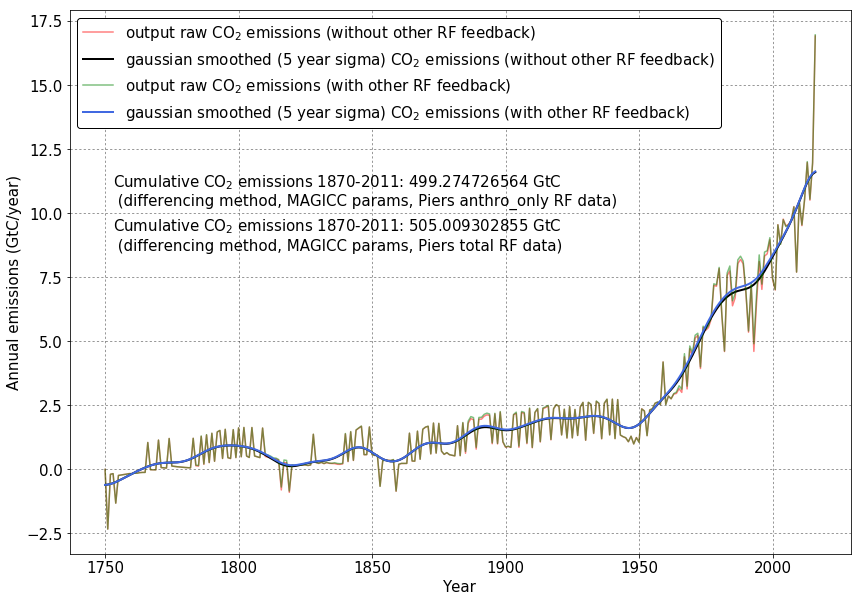

In [4]:
#MAGICC params, Piers RF data run through to find CO2 emissions.
#Use total forcing including natural sources, and tell function which bits are other rf
#   and which are as a result of emissions
#Use differencing method to find contribution from CO2 only
#-----------------

#using anthropogenic emissions and differencing approach (Piers data)
out2 = FAIR_model(other_rf = rf_anthro_median - rf_comps_median[:,1], MAGICC_model = True, F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)
temp_total2 = out2['temperature']
conc_total2 = fair_inverse_revised.forcing_to_conc(rf_anthro_median - rf_comps_median[:,1], a = F_2x/np.log(2) , Cpreind = C_0)
ems_total2, ems_total_smooth2 = fair_inverse_revised.conc_to_emissions(conc_total2, temp_total2, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)

out3 = FAIR_model(other_rf = rf_anthro_median, MAGICC_model = True, F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)
temp_total3 = out3['temperature']
conc_total3 = fair_inverse_revised.forcing_to_conc(rf_anthro_median, a = F_2x/np.log(2) , Cpreind = C_0)
ems_total3, ems_total_smooth3 = fair_inverse_revised.conc_to_emissions(conc_total3, temp_total3, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)

ems_co2 = ems_total3 - ems_total2
ems_test_smooth = ems_total_smooth3 - ems_total_smooth2

plt.plot(time, ems_co2, color = 'red', alpha = 0.5, label = 'output raw CO$_2$ emissions (without other RF feedback)')
plt.plot(time, ems_test_smooth, color = 'black', linewidth = 2, label = 'gaussian smoothed (5 year sigma) CO$_2$ emissions (without other RF feedback)')
plt.xlabel('Year')
plt.ylabel('Annual emissions (GtC/year)')
plt.grid(True, linestyle = ':', color = 'black', alpha = 0.5)
cum_co2 = np.cumsum(ems_test_smooth[1870-1750:])
plt.text(1753, 10.3, 'Cumulative CO$_2$ emissions 1870-2011: %s GtC \n (differencing method, MAGICC params, Piers anthro_only RF data)' %cum_co2[2011-1870])
plt.legend(loc = 'best', framealpha = 1, edgecolor = 'black')

#--------------

#using total RF and differencing approach (Piers data)
out4 = FAIR_model(other_rf = rf_total_median - rf_comps_median[:,1], MAGICC_model = True, F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)
temp_total4 = out4['temperature']
conc_total4 = fair_inverse_revised.forcing_to_conc(rf_total_median - rf_comps_median[:,1], RF_ext = rf_other_median, RF_ext_in = True, a = F_2x/np.log(2) , Cpreind = C_0)
ems_total4, ems_total_smooth4 = fair_inverse_revised.conc_to_emissions(conc_total4, temp_total4, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)

out5 = FAIR_model(other_rf = rf_total_median, MAGICC_model = True, F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)
temp_total5 = out5['temperature']
conc_total5 = fair_inverse_revised.forcing_to_conc(rf_total_median, RF_ext = rf_other_median, RF_ext_in = True, a = F_2x/np.log(2) , Cpreind = C_0)
ems_total5, ems_total_smooth5 = fair_inverse_revised.conc_to_emissions(conc_total5, temp_total5, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)

ems_co2_again = ems_total5 - ems_total4
ems_test_smooth_again = ems_total_smooth5 - ems_total_smooth4

plt.plot(time, ems_co2_again, color = 'green', alpha = 0.5, label = 'output raw CO$_2$ emissions (with other RF feedback)')
plt.plot(time, ems_test_smooth_again, color = 'royalblue', linewidth = 2, label = 'gaussian smoothed (5 year sigma) CO$_2$ emissions (with other RF feedback)')
plt.xlabel('Year')
plt.ylabel('Annual emissions (GtC/year)')
plt.grid(True, linestyle = ':', color = 'black', alpha = 0.5)
cum_co2_again = np.cumsum(ems_test_smooth_again[1870-1750:])
plt.text(1753, 8.6, 'Cumulative CO$_2$ emissions 1870-2011: %s GtC \n (differencing method, MAGICC params, Piers total RF data)' %cum_co2_again[2011-1870])
plt.legend(loc = 'best', framealpha = 1, edgecolor = 'black')

#---------------

#plt.savefig('CO2_emissions_PIERSDATA_MAGICC_params')

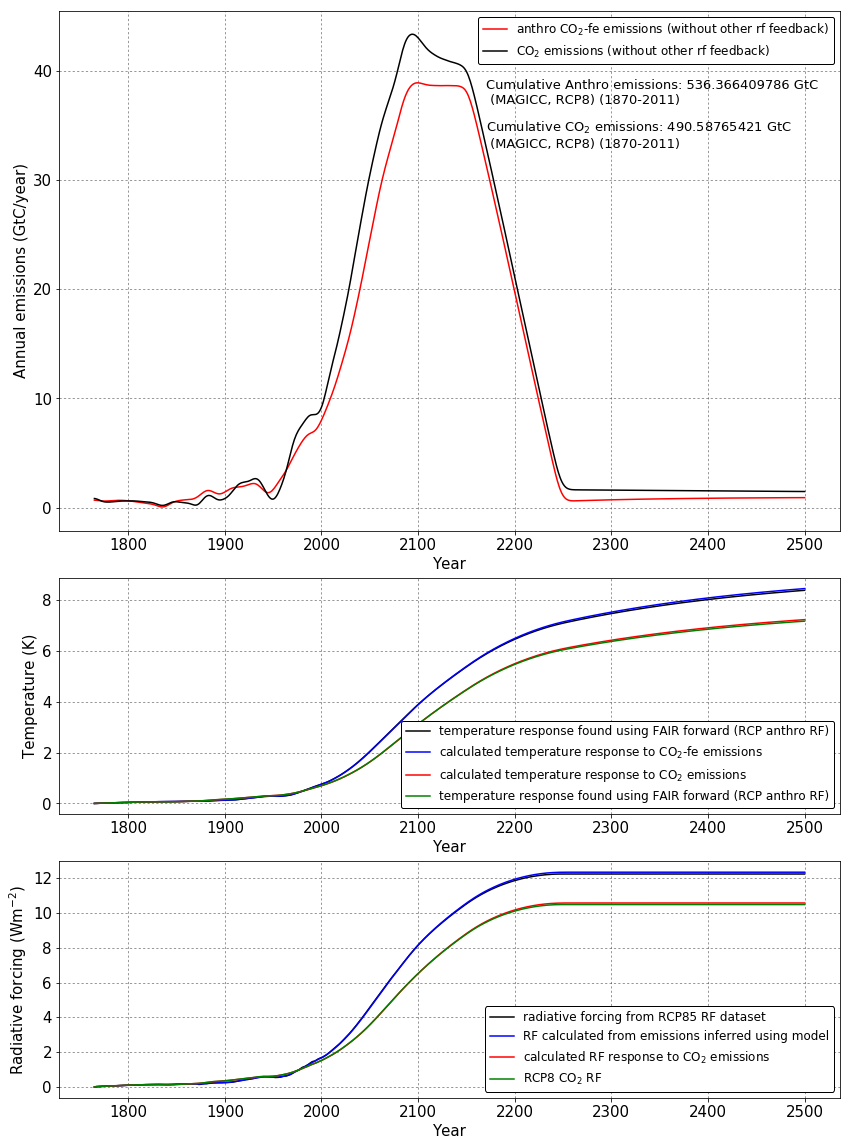

In [5]:
# NOW doing the same calculations for RCP datasets

#importing RCP8 data
datafile = 'RCP85'

emms_file = './RCPs/' + datafile + '_EMISSIONS.csv'
emms_data = np.genfromtxt(emms_file,skip_header=36,delimiter=',',names=True)

emissions = emms_data['FossilCO2'] + emms_data['OtherCO2']
M_emissions = emms_data['CH4']
N_emissions = emms_data['N2O'] * 44.0 / 28.0

forc_file = './RCPs/'+datafile+'_MIDYEAR_RADFORCING.csv'
forc_data = np.genfromtxt(forc_file,skip_header=58,delimiter=',',names=True)
other_rf = forc_data['TOTAL_ANTHRO_RF'] - forc_data['CO2_RF'] - forc_data['CH4_RF'] - forc_data['N2O_RF']

#-------------------

#total anthropogenic from RF forcing file
out_anthro_RCP8 = FAIR_model(other_rf = forc_data['TOTAL_ANTHRO_RF'], MAGICC_model = True, F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)
temp_anthro_RCP8 = out_anthro_RCP8['temperature']
conc_anthro_RCP8 = fair_inverse_revised.forcing_to_conc(forc_data['TOTAL_ANTHRO_RF'], a = F_2x/np.log(2) , Cpreind = C_0)
ems_anthro_RCP8, ems_anthro_RCP8_smooth = fair_inverse_revised.conc_to_emissions(conc_anthro_RCP8, temp_anthro_RCP8, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)

#total minus CO2 from RF file
out_anthro_minus_co2_RCP8 = FAIR_model(other_rf = forc_data['TOTAL_ANTHRO_RF'] - forc_data['CO2_RF'], MAGICC_model = True, F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)
temp_anthro_minus_co2_RCP8 = out_anthro_minus_co2_RCP8['temperature']
conc_anthro_minus_co2_RCP8 = fair_inverse_revised.forcing_to_conc(forc_data['TOTAL_ANTHRO_RF'] - forc_data['CO2_RF'], a = F_2x/np.log(2) , Cpreind = C_0)
ems_anthro_minus_co2_RCP8, ems_anthro_minus_co2_RCP8_smooth = fair_inverse_revised.conc_to_emissions(conc_anthro_minus_co2_RCP8, temp_anthro_minus_co2_RCP8, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)

#just co2...
ems_co2_RCP8 = ems_anthro_RCP8_smooth - ems_anthro_minus_co2_RCP8_smooth

#reverse calculate rf and temp from our emissions
out_anthro_only = FAIR_model(emissions = ems_anthro_RCP8_smooth, MAGICC_model = True, F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)
out_anthro_minus_co2_only = FAIR_model(emissions = ems_anthro_minus_co2_RCP8_smooth, MAGICC_model = True, F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)
temp_co2_only = out_anthro_only['temperature'] - out_anthro_minus_co2_only['temperature']
rf_co2_only = out_anthro_only['forcing']['total'] - out_anthro_minus_co2_only['forcing']['total']

#cumulative emissions calc
cum_anthro_RCP8 = np.cumsum(ems_anthro_RCP8_smooth[1870-1765:])
cum_co2_RCP8 = np.cumsum(ems_co2_RCP8[1870-1765:])

#plotting
plt.figure(figsize = (14,20))
ax3 = plt.subplot2grid((4,2), (0,0), colspan = 2, rowspan = 2)
ax4 = plt.subplot2grid((4,2), (2,0), colspan = 2)
ax5 = plt.subplot2grid((4,2), (3,0), colspan = 2)

ax3.plot(np.arange(1765,2501), ems_co2_RCP8, color = 'red', label = 'anthro CO$_2$-fe emissions (without other rf feedback)')
ax3.plot(np.arange(1765,2501), ems_anthro_RCP8_smooth, color = 'black', label = 'CO$_2$ emissions (without other rf feedback)')
ax3.grid(True, linestyle = ':', alpha = 0.5, color = 'black')
ax3.set_xlabel('Year')
ax3.set_ylabel('Annual emissions (GtC/year)')
ax3.legend(loc = 'best', framealpha = 1, edgecolor = 'black', fontsize = 12)
ax3.text(2170,37, 'Cumulative Anthro emissions: %s GtC \n (MAGICC, RCP8) (1870-2011)' %cum_anthro_RCP8[2011-1870], fontsize = 13)
ax3.text(2170,33, 'Cumulative CO$_2$ emissions: %s GtC \n (MAGICC, RCP8) (1870-2011)' %cum_co2_RCP8[2011-1870], fontsize = 13)

ax4.plot(np.arange(1765,2501), temp_anthro_RCP8, color = 'black', label = 'temperature response found using FAIR forward (RCP anthro RF)')
ax4.plot(np.arange(1765,2501), out_anthro_only['temperature'], color = 'blue', label = 'calculated temperature response to CO$_2$-fe emissions')
ax4.plot(np.arange(1765,2501), temp_co2_only, color = 'red', label = 'calculated temperature response to CO$_2$ emissions')
ax4.plot(np.arange(1765,2501), temp_anthro_RCP8 - temp_anthro_minus_co2_RCP8, color = 'green', label = 'temperature response found using FAIR forward (RCP anthro RF)')
ax4.grid(True, linestyle = ':', alpha = 0.5, color = 'black')
ax4.set_xlabel('Year')
ax4.set_ylabel('Temperature (K)')
ax4.legend(loc = 'best', framealpha = 1, edgecolor = 'black', fontsize = 12)

ax5.plot(np.arange(1765,2501), forc_data['TOTAL_ANTHRO_RF'], color = 'black', label = 'radiative forcing from RCP85 RF dataset')
ax5.plot(np.arange(1765,2501), out_anthro_only['forcing']['total'], color = 'blue', label = 'RF calculated from emissions inferred using model')
ax5.plot(np.arange(1765,2501), rf_co2_only, color = 'red', label = 'calculated RF response to CO$_2$ emissions')
ax5.plot(np.arange(1765,2501), forc_data['CO2_RF'], color = 'green', label = 'RCP8 CO$_2$ RF')
ax5.grid(True, linestyle = ':', alpha = 0.5, color = 'black')
ax5.set_xlabel('Year')
ax5.set_ylabel('Radiative forcing (Wm$^{-2}$)')
ax5.legend(loc = 'best', framealpha = 1, edgecolor = 'black', fontsize = 12)

#plt.savefig('RCP8DATA_MAGICC_params_cumulative_ems')

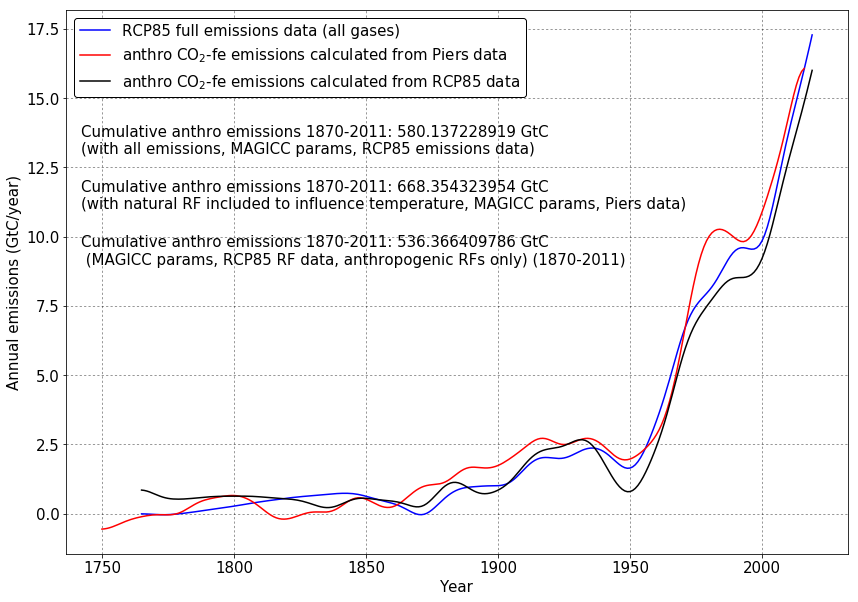

In [6]:
#finding total emissions response to RCP85 emissions dataset
out_test = FAIR_model(emissions = emissions, M_emissions = M_emissions, N_emissions = N_emissions, other_rf = other_rf,
                      MAGICC_model = True, N_0=270.0, S_OH_CH4 = -0.32, 
                      S_T_CH4 = 0.035, tau_M_0 = 9.0, F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)
temp_test = out_test['temperature']
forc_test = out_test['forcing']['total']
conc_test = fair_inverse_revised.forcing_to_conc(forc_test, a = F_2x/np.log(2) , Cpreind = C_0)
ems_test, ems_test_smoother = fair_inverse_revised.conc_to_emissions(conc_test, temp_test, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)

ems_1870_2011 = ems_anthro_RCP8_smooth[:2020-1765]
ems_rcp85_1870_onwards = np.cumsum(ems_test_smoother[1870-1765:])

plt.plot(np.arange(1765,2020), ems_test_smoother[:2020-1765], color = 'blue', label = 'RCP85 full emissions data (all gases) ')
plt.plot(time, ems_anthro_smooth, color = 'red', label = 'anthro CO$_2$-fe emissions calculated from Piers data')
plt.plot(np.arange(1765,2020), ems_1870_2011, color = 'black', label = 'anthro CO$_2$-fe emissions calculated from RCP85 data')
plt.grid(True, linestyle = ':', color = 'black', alpha = 0.5)
plt.legend(loc = 'best', framealpha = 1, edgecolor = 'black')
plt.xlabel('Year')
plt.ylabel('Annual emissions (GtC/year)')
plt.text(1742,13,'Cumulative anthro emissions 1870-2011: %s GtC \n(with all emissions, MAGICC params, RCP85 emissions data)' %ems_rcp85_1870_onwards[2011-1870])
plt.text(1742,11,'Cumulative anthro emissions 1870-2011: %s GtC \n(with natural RF included to influence temperature, MAGICC params, Piers data)' %cum_ems[2011-1870])
plt.text(1742,9,'Cumulative anthro emissions 1870-2011: %s GtC \n (MAGICC params, RCP85 RF data, anthropogenic RFs only) (1870-2011)' %cum_anthro_RCP8[2011-1870])

#plt.savefig('comparison_of_RCP_and_piers_data')

In [7]:
#for rcp85 data
cum_rcp_1765_2011 = np.cumsum(ems_co2_RCP8)
print 'RCP85 cumulative CO$_2$ emissions 1765-2011 inclusive: %s GtC' % cum_rcp_1765_2011[2011-1765]

cum_rcp_1870_2016 = np.cumsum(ems_co2_RCP8[1870-1765:])
print 'RCP85 cumulative CO$_2$ emissions 1870-2016 inclusive: %s GtC' % cum_rcp_1870_2016[2016-1870]

cumanthro_rcp_1765_2011 = np.cumsum(ems_test_smoother)
print 'RCP85 cumulative anthro CO$_2$-fe emissions 1765-2011 inclusive: %s GtC' % cumanthro_rcp_1765_2011[2011-1765]

cumanthro_rcp_1870_2016 = np.cumsum(ems_test_smoother[1870-1765:])
print 'RCP85 cumulative anthro CO$_2$-fe emissions 1870-2016 inclusive: %s GtC' % cumanthro_rcp_1870_2016[2016-1870]

#for piers data, w/out natural RF
cum_rcp_1765_2011_p = np.cumsum(ems_test_smooth[1765-1750:])
print 'Piers data w/out nat rf cumulative CO$_2$ emissions 1765-2011 inclusive: %s GtC' % cum_rcp_1765_2011_p[2011-1765]

cum_rcp_1870_2016_p = np.cumsum(ems_test_smooth[1870-1750:])
print 'Piers data w/out nat rf cumulative CO$_2$ emissions 1870-2016 inclusive: %s GtC' % cum_rcp_1870_2016_p[2016-1870]

cumanthro_rcp_1765_2011_p = np.cumsum(ems_anthro_smooth[1765-1750:])
print 'Piers data w/out nat rf cumulative anthro CO$_2$-fe emissions 1765-2011 inclusive: %s GtC' % cumanthro_rcp_1765_2011_p[2011-1765]

cumanthro_rcp_1870_2016_p = np.cumsum(ems_anthro_smooth[1870-1750:])
print 'Piers data w/out nat rf cumulative anthro CO$_2$-fe emissions 1870-2016 inclusive: %s GtC' % cumanthro_rcp_1870_2016_p[2016-1870]

#for piers data, w/ natural RF
cum_rcp_1765_2011_p2 = np.cumsum(ems_test_smooth_again[1765-1750:])
print 'Piers data w/ nat rf cumulative CO$_2$ emissions 1765-2011 inclusive: %s GtC' % cum_rcp_1765_2011_p2[2011-1765]

cum_rcp_1870_2016_p2 = np.cumsum(ems_test_smooth_again[1870-1750:])
print 'Piers data w/ nat rf cumulative CO$_2$ emissions 1870-2016 inclusive: %s GtC' % cum_rcp_1870_2016_p2[2016-1870]

cumanthro_rcp_1765_2011_p2 = np.cumsum(ems_total_smooth[1765-1750:])
print 'Piers data w/ nat rf cumulative anthro CO$_2$-fe emissions 1765-2011 inclusive: %s GtC' % cumanthro_rcp_1765_2011_p2[2011-1765]

cumanthro_rcp_1870_2016_p2 = np.cumsum(ems_total_smooth[1870-1750:])
print 'Piers data w/ nat rf cumulative anthro CO$_2$-fe emissions 1870-2016 inclusive: %s GtC' % cumanthro_rcp_1870_2016_p2[2016-1870]

RCP85 cumulative CO$_2$ emissions 1765-2011 inclusive: 546.780322896 GtC
RCP85 cumulative CO$_2$ emissions 1870-2016 inclusive: 546.589787697 GtC
RCP85 cumulative anthro CO$_2$-fe emissions 1765-2011 inclusive: 617.138352733 GtC
RCP85 cumulative anthro CO$_2$-fe emissions 1870-2016 inclusive: 656.504753538 GtC
Piers data w/out nat rf cumulative CO$_2$ emissions 1765-2011 inclusive: 553.181614331 GtC
Piers data w/out nat rf cumulative CO$_2$ emissions 1870-2016 inclusive: 555.960258117 GtC
Piers data w/out nat rf cumulative anthro CO$_2$-fe emissions 1765-2011 inclusive: 685.842167692 GtC
Piers data w/out nat rf cumulative anthro CO$_2$-fe emissions 1870-2016 inclusive: 738.464825036 GtC
Piers data w/ nat rf cumulative CO$_2$ emissions 1765-2011 inclusive: 560.181689742 GtC
Piers data w/ nat rf cumulative CO$_2$ emissions 1870-2016 inclusive: 561.826734523 GtC
Piers data w/ nat rf cumulative anthro CO$_2$-fe emissions 1765-2011 inclusive: 694.539663387 GtC
Piers data w/ nat rf cumulativ

(-0.5, 3)

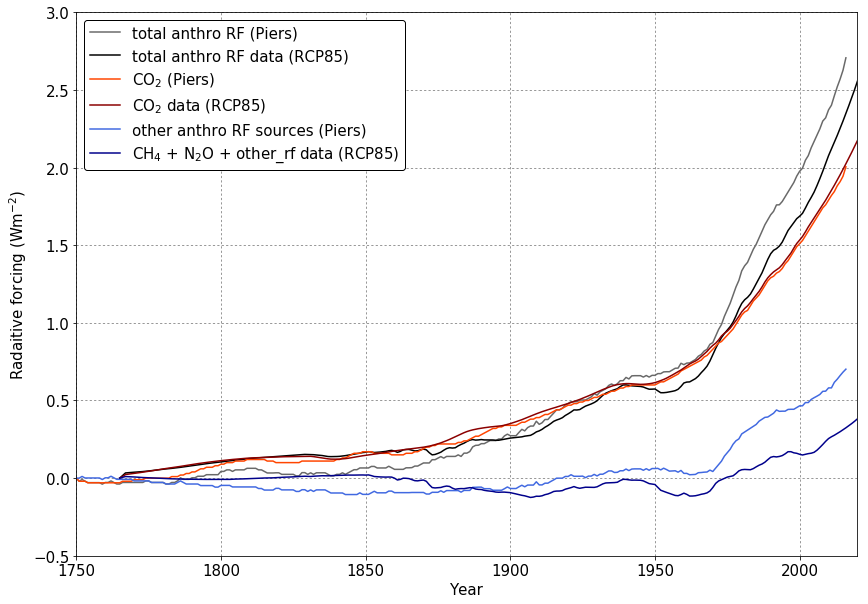

In [8]:
#plotting all the contributions to Piers total RF data and comparing to contributors in the RCP85 files

plt.plot(np.arange(1750,2017), rf_comps_median[:,1] + rf_comps_median[:,2] + rf_comps_median[:,3] + rf_comps_median[:,4] + rf_comps_median[:,6] + rf_comps_median[:,7] + rf_comps_median[:,8] + rf_comps_median[:,9] +  rf_comps_median[:,10], color = 'dimgray', label = 'total anthro RF (Piers)')
plt.plot(np.arange(1765,2501), forc_data['TOTAL_ANTHRO_RF'], color = 'black', label = 'total anthro RF data (RCP85)')

plt.plot(np.arange(1750,2017), rf_comps_median[:,1], color = 'orangered', label = 'CO$_2$ (Piers)')
plt.plot(np.arange(1765,2501), forc_data['CO2_RF'], color = 'darkred', label = 'CO$_2$ data (RCP85)')

plt.plot(np.arange(1750,2017), rf_comps_median[:,2] + rf_comps_median[:,3] + rf_comps_median[:,4] + rf_comps_median[:,6] + rf_comps_median[:,7] + rf_comps_median[:,8] + rf_comps_median[:,9] +  rf_comps_median[:,10], color = 'royalblue', label = 'other anthro RF sources (Piers)')
plt.plot(np.arange(1765,2501), forc_data['CH4_RF'] + forc_data['N2O_RF'] + other_rf, color = 'darkblue', label = 'CH$_4$ + N$_2$O + other_rf data (RCP85)')

plt.xlim(1750,2020)
plt.legend(loc = 'best', framealpha = 1, edgecolor = 'black')
plt.grid(True, linestyle = ':', color = 'black', alpha = 0.5)
plt.xlabel('Year')
plt.ylabel('Radaitive forcing (Wm$^{-2}$)')
plt.ylim(-0.5,3)

#plt.savefig('comparison_RFs_rcp85vspiers')

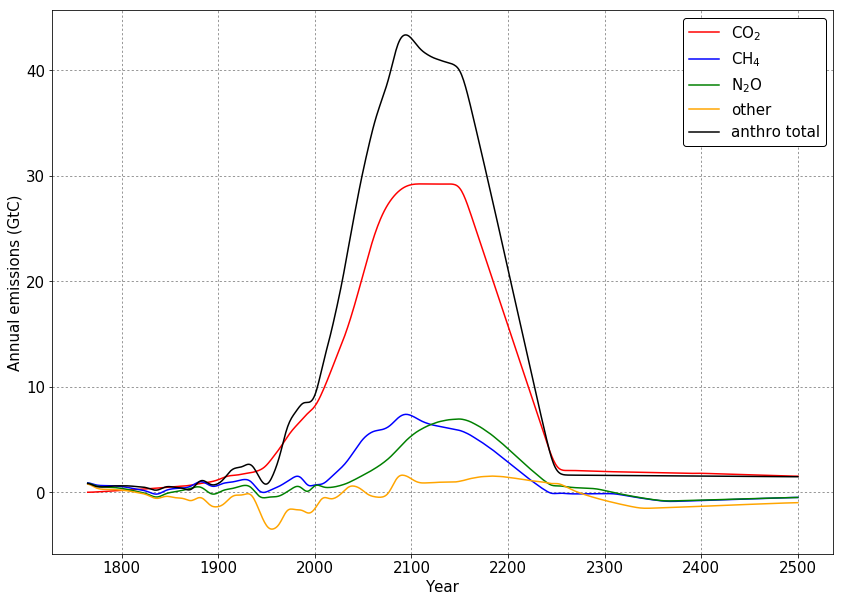

In [9]:
#total anthro
out_total = FAIR_model(other_rf = forc_data['TOTAL_ANTHRO_RF'], MAGICC_model = True, N_0=270.0, S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0, F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)
conc_anthro_total = fair_inverse_revised.forcing_to_conc(forc_data['TOTAL_ANTHRO_RF'], a = F_2x/np.log(2) , Cpreind = C_0)
ems_anthro_total, ems_anthro_total_smoothed = fair_inverse_revised.conc_to_emissions(conc_anthro_total, out_total['temperature'], pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)
#-------------
out_CO2 = FAIR_model(emissions = emissions,MAGICC_model = True, N_0=270.0, S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0, F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)
temp_CO2 = out_CO2['temperature']
forc_CO2 = out_CO2['forcing']['total']
conc_CO2 = fair_inverse_revised.forcing_to_conc(forc_CO2, a = F_2x/np.log(2) , Cpreind = C_0)
ems_CO2, ems_CO2_smoother = fair_inverse_revised.conc_to_emissions(conc_CO2, temp_CO2, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)
#-------------
out_minusCH4 = FAIR_model(emissions = emissions, N_emissions = N_emissions, other_rf = other_rf,
                      MAGICC_model = True, N_0=270.0, S_OH_CH4 = -0.32, 
                      S_T_CH4 = 0.035, tau_M_0 = 9.0, F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)
temp_minusCH4 = out_minusCH4['temperature']
forc_minusCH4 = out_minusCH4['forcing']['total']
conc_minusCH4 = fair_inverse_revised.forcing_to_conc(forc_minusCH4, a = F_2x/np.log(2) , Cpreind = C_0)
ems_minusCH4, ems_minusCH4_smoother = fair_inverse_revised.conc_to_emissions(conc_minusCH4, temp_minusCH4, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)

ems_CH4 = ems_anthro_RCP8_smooth - ems_minusCH4_smoother
#-------------
out_minusN2O = FAIR_model(emissions = emissions, M_emissions = M_emissions, other_rf = other_rf,
                      MAGICC_model = True, N_0=270.0, S_OH_CH4 = -0.32, 
                      S_T_CH4 = 0.035, tau_M_0 = 9.0, F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)
temp_minusN2O = out_minusN2O['temperature']
forc_minusN2O = out_minusN2O['forcing']['total']
conc_minusN2O = fair_inverse_revised.forcing_to_conc(forc_minusN2O, a = F_2x/np.log(2) , Cpreind = C_0)
ems_minusN2O, ems_minusN2O_smoother = fair_inverse_revised.conc_to_emissions(conc_minusN2O, temp_minusN2O, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)

ems_N2O = ems_anthro_RCP8_smooth - ems_minusN2O_smoother
#--------------
out_minusother = FAIR_model(emissions = emissions, M_emissions = M_emissions, N_emissions = N_emissions,
                      MAGICC_model = True, N_0=270.0, S_OH_CH4 = -0.32, 
                      S_T_CH4 = 0.035, tau_M_0 = 9.0, F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)
temp_minusother = out_minusother['temperature']
forc_minusother = out_minusother['forcing']['total']
conc_minusother = fair_inverse_revised.forcing_to_conc(forc_minusother, a = F_2x/np.log(2) , Cpreind = C_0)
ems_minusother, ems_minusother_smoother = fair_inverse_revised.conc_to_emissions(conc_minusother, temp_minusother, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)

ems_other = ems_anthro_RCP8_smooth - ems_minusother_smoother
#---------------

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(np.arange(1765,2501), ems_CO2_smoother, color = 'red', label = 'CO$_2$')
ax1.grid(True, linestyle = ':', color = 'black', alpha = 0.5)
ax1.set_xlabel('Year')
ax1.set_ylabel('Annual emissions (GtC)')
ax1.plot(np.arange(1765,2501), ems_CH4, color = 'blue', label = 'CH$_4$')
ax1.plot(np.arange(1765,2501), ems_N2O, color = 'green', label = 'N$_2$O')
ax1.plot(np.arange(1765,2501), ems_other, color = 'orange', label = 'other')
ax1.plot(np.arange(1765,2501), ems_anthro_total_smoothed, color = 'black', label = 'anthro total')
ax1.legend(loc = 'best', framealpha = 1, edgecolor = 'black')

#fig.savefig('RCP85_contributions_to_total_co2-fe_ems')
